In [14]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data = pd.read_csv("/Users/alexren/Desktop/UC Davis/ECS 170/dirty_v3_path.csv")

data.head()

,Age,Gender,Medical Condition,Glucose,Blood Pressure,BMI,Oxygen Saturation,LengthOfStay,Cholesterol,Triglycerides,HbA1c,Smoking,Alcohol,Physical Activity,Diet Score,Family History,Stress Level,Sleep Hours,random_notes,noise_col
0,46.0,Male,Diabetes,137.04,135.27,28.90,96.04,6,231.88,210.56,7.61,0,0,-0.20,3.54,0,5.07,6.05,lorem,-137.057211
1,22.0,Male,Healthy,71.58,113.27,26.29,97.54,2,165.57,129.41,4.91,0,0,8.12,5.90,0,5.87,7.72,ipsum,-11.230610
2,50.0,NaN,Asthma,95.24,NaN,22.53,90.31,2,214.94,165.35,5.60,0,0,5.01,4.65,1,3.09,4.82,ipsum,98.331195
3,57.0,NaN,Obesity,NaN,130.53,38.47,96.60,5,197.71,182.13,6.92,0,0,3.16,3.37,0,3.01,5.33,lorem,44.187175
4,66.0,Female,Hypertension,95.15,178.17,31.12,94.90,4,259.53,115.85,5.98,0,1,3.56,3.40,0,6.38,6.64,lorem,44.831426


In [16]:
data.shape
data['Medical Condition'].value_counts()

Medical Condition
Hypertension    7120
Diabetes        6417
Obesity         3857
Healthy         3039
Asthma          2037
Arthritis       1796
Cancer          1234
Name: count, dtype: int64

In [17]:
data = data.drop(['random_notes', 'noise_col'], axis=1)
data = data.dropna(subset=['Medical Condition']).copy()

In [18]:
X = data.drop(['Medical Condition'], axis = 1)
y = data['Medical Condition']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Total samples after cleaning: {len(X)}")
print(f"Number of classes after cleaning: {len(y.unique())}")

Total samples after cleaning: 25500
Number of classes after cleaning: 7


In [5]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y_encoded, train_size = 0.7, random_state=42, stratify = y_encoded)

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, random_state=42, stratify = y_rest)

# - Split into 70% for training set, 15% for validation set, 15% for testing set
#   - 17850 for the training set
#   - 3825 for the testing set
#   - 3825 for the validation set

In [6]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
print(numerical_features)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

['Age', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation', 'LengthOfStay', 'Cholesterol', 'Triglycerides', 'HbA1c', 'Smoking', 'Alcohol', 'Physical Activity', 'Diet Score', 'Family History', 'Stress Level', 'Sleep Hours']
['Gender']


In [7]:
numerical_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)), 
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [8]:
# Building the model

lgb_model = lgb.LGBMClassifier(objective = 'multiclass', num_class=len(y.unique()), n_estimators=1000, learning_rate=0.05, 
                               max_depth=-1, num_leaves = 31, random_state=42, lambda_l1=0.1, lambda_l2=0.1, colsample_bytree=0.8, 
                               subsample=0.8, subsample_freq=1, n_jobs=-1, class_weight='balanced')

In [9]:
lgb_model.fit(X_train, y_train)

y_pred_train_lgb = lgb_model.predict(X_train)

print(classification_report(y_train, y_pred_train_lgb))

y_pred_val_lgb = lgb_model.predict(X_val)

print(classification_report(y_val, y_pred_val_lgb))

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3043
[LightGBM] [Info] Number of data points in the train set: 17850, number of used features: 18
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info]

/Users/alexren/ecs170/ecs170-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1426
           2       1.00      1.00      1.00       864
           3       1.00      1.00      1.00      4492
           4       1.00      1.00      1.00      2127
           5       1.00      1.00      1.00      4984
           6       1.00      1.00      1.00      2700

    accuracy                           1.00     17850
   macro avg       1.00      1.00      1.00     17850
weighted avg       1.00      1.00      1.00     17850

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lam

/Users/alexren/ecs170/ecs170-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.69      0.72       269
           1       0.94      0.94      0.94       306
           2       0.99      0.99      0.99       185
           3       0.96      0.94      0.95       962
           4       0.99      0.99      0.99       456
           5       0.89      0.92      0.91      1068
           6       0.90      0.90      0.90       579

    accuracy                           0.92      3825
   macro avg       0.92      0.91      0.91      3825
weighted avg       0.92      0.92      0.92      3825



In [10]:
from hyperopt import hp, STATUS_OK, fmin, tpe
from sklearn.model_selection import cross_val_score, StratifiedKFold

space_lgbm = {
    "learning_rate": hp.loguniform("learning_rate", -3, -1),
    "num_leaves": hp.quniform("num_leaves", 15, 60, 1),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "n_estimators": hp.quniform("n_estimators", 200, 500, 100),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
    "lambda_l2": hp.loguniform("lambda_l2", -4, -1),
    "lambda_l1": hp.loguniform("lambda_l1", -4, -1),
}

def objective_lgbm(params):
    
    params["num_leaves"] = int(params["num_leaves"])
    params["max_depth"] = int(params["max_depth"])
    params["n_estimators"] = int(params["n_estimators"])

    model = lgb.LGBMClassifier(
        objective="multiclass",
        num_class=len(y.unique()),
        random_state=42,
        n_jobs=-1,
        class_weight='balanced', 
        **params
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1)

    mean_score = scores.mean()
    
    return {'loss': -mean_score, 'status': STATUS_OK}

/Users/alexren/ecs170/ecs170-env/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
import warnings
warnings.filterwarnings('ignore')

best_params = fmin(fn=objective_lgbm, space=space_lgbm, algo=tpe.suggest, max_evals=100)

integer_keys = ["num_leaves", "max_depth", "n_estimators"]
for k in integer_keys:
    if k in best_params:
        best_params[k] = int(best_params[k])

float_keys = ["learning_rate", "subsample", "colsample_bytree", "lambda_l2", "lambda_l1"]
for k in float_keys:
    if k in best_params:
        best_params[k] = float(best_params[k])

print("\n--- Optimized LightGBM Hyperparameters ---")
for k, v in best_params.items():
    print(f"'{k}': {v},")
print("------------------------------------------")

# --- Optimized LightGBM Hyperparameters ---
# 'colsample_bytree': 0.5654906859725422,
# 'lambda_l1': 0.03851714860588453,
# 'lambda_l2': 0.1259526579112942,
# 'learning_rate': 0.060008656421984594,
# 'max_depth': 8,
# 'n_estimators': 300,
# 'num_leaves': 50,
# 'subsample': 0.6637433508593842,
# ------------------------------------------


In [11]:
best_parameters = {'colsample_bytree': 0.5654906859725422,
                   'lambda_l1': 0.03851714860588453,
                   'lambda_l2': 0.1259526579112942,
                   'learning_rate': 0.060008656421984594,
                   'max_depth': 8,
                   'n_estimators': 300,
                   'num_leaves': 50,
                   'subsample': 0.6637433508593842}

In [12]:
lgb_model_optimized = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(y.unique()),
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    **best_parameters
)

lgb_model_optimized.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.03851714860588453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03851714860588453
[LightGBM] [Warning] lambda_l2 is set=0.1259526579112942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1259526579112942
[LightGBM] [Warning] lambda_l1 is set=0.03851714860588453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03851714860588453
[LightGBM] [Warning] lambda_l2 is set=0.1259526579112942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1259526579112942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3043
[LightGBM] [Info] Number of data points in the train set: 17850, number of used features: 18
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] 

,boosting_type,'gbdt'
,num_leaves,50
,max_depth,8
,learning_rate,0.060008656421984594
,n_estimators,300
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [13]:
lgb_model_optimized.fit(X_train, y_train)

y_pred_train_lgb = lgb_model_optimized.predict(X_train)

print(classification_report(y_train, y_pred_train_lgb))

y_pred_val_lgb = lgb_model_optimized.predict(X_val)

print(classification_report(y_val, y_pred_val_lgb))

[LightGBM] [Warning] lambda_l1 is set=0.03851714860588453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03851714860588453
[LightGBM] [Warning] lambda_l2 is set=0.1259526579112942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1259526579112942
[LightGBM] [Warning] lambda_l1 is set=0.03851714860588453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03851714860588453
[LightGBM] [Warning] lambda_l2 is set=0.1259526579112942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1259526579112942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3043
[LightGBM] [Info] Number of data points in the train set: 17850, number of used features: 18
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] 

/Users/alexren/ecs170/ecs170-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=0.03851714860588453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03851714860588453
[LightGBM] [Warning] lambda_l2 is set=0.1259526579112942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1259526579112942
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1426
           2       1.00      1.00      1.00       864
           3       1.00      1.00      1.00      4492
           4       1.00      1.00      1.00      2127
           5       1.00      1.00      1.00      4984
           6       1.00      1.00      1.00      2700

    accuracy                           1.00     17850
   macro avg       1.00      1.00      1.00     17850
weighted avg       1.00      1.00      1.00     17850

[LightGBM] [Warning] lambda_l1 is set=0.03851714860588453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03851714860588453

/Users/alexren/ecs170/ecs170-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [14]:
y_pred_test_lgb = lgb_model_optimized.predict(X_test)

print(classification_report(y_test, y_pred_test_lgb))

accuracy = accuracy_score(y_test, y_pred_test_lgb)
print(f"Accuracy: {accuracy}")

[LightGBM] [Warning] lambda_l1 is set=0.03851714860588453, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03851714860588453
[LightGBM] [Warning] lambda_l2 is set=0.1259526579112942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1259526579112942
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       270
           1       0.92      0.89      0.90       305
           2       0.98      0.97      0.98       185
           3       0.97      0.95      0.96       963
           4       0.99      1.00      0.99       456
           5       0.90      0.90      0.90      1068
           6       0.90      0.90      0.90       578

    accuracy                           0.91      3825
   macro avg       0.90      0.90      0.90      3825
weighted avg       0.92      0.91      0.92      3825

Accuracy: 0.9147712418300653


/Users/alexren/ecs170/ecs170-env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


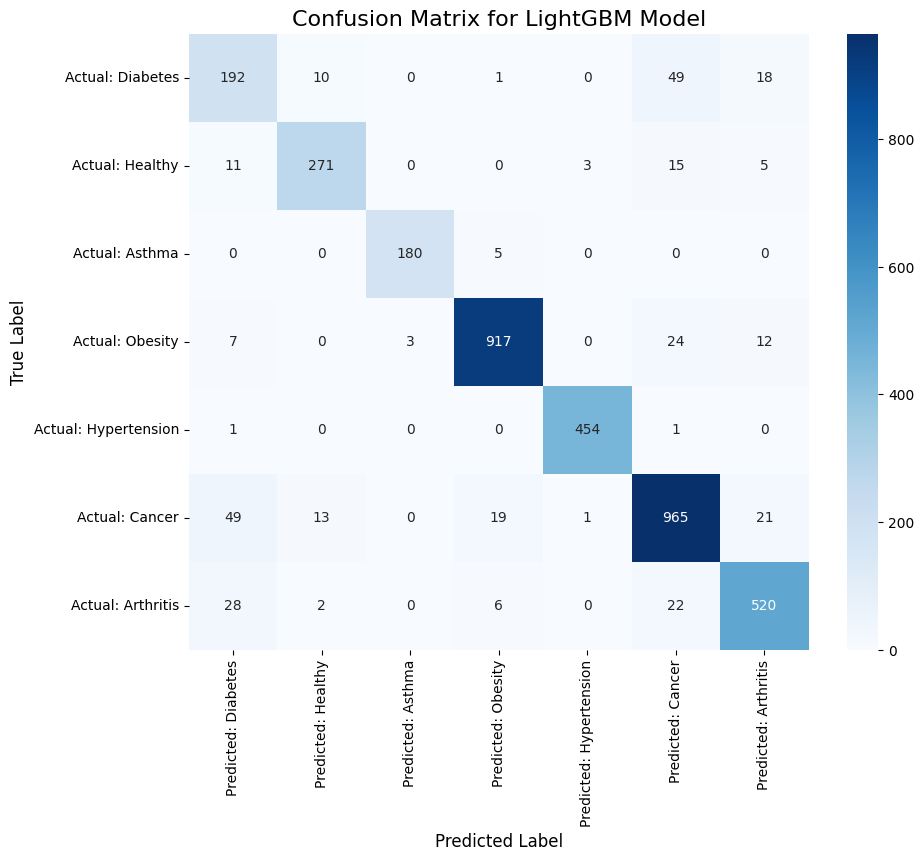

In [15]:
cm = confusion_matrix(y_test, y_pred_test_lgb)

class_labels = []

for i in y.unique():
    class_labels.append(i)

cm_df = pd.DataFrame(
    data = cm, 
    index=[f'Actual: {label}' for label in class_labels], 
    columns=[f'Predicted: {label}' for label in class_labels]
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_df, 
    annot=True,     
    fmt='d',        
    cmap='Blues', 
    cbar=True
)

plt.title('Confusion Matrix for LightGBM Model', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [16]:
num_features = 18
print(numerical_features)
print(categorical_features)

['Age', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation', 'LengthOfStay', 'Cholesterol', 'Triglycerides', 'HbA1c', 'Smoking', 'Alcohol', 'Physical Activity', 'Diet Score', 'Family History', 'Stress Level', 'Sleep Hours']
['Gender']


In [17]:
ohe_transformer = preprocessor.named_transformers_['categorical']
ohe_feature_names = ohe_transformer.get_feature_names_out(categorical_features)
print(ohe_feature_names)

['Gender_Female' 'Gender_Male']


In [18]:
categorical_ohe_features = [
    'Gender_Male', 
    'Gender_Female',
]

feature_names = numerical_features + categorical_ohe_features
print(feature_names)

['Age', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation', 'LengthOfStay', 'Cholesterol', 'Triglycerides', 'HbA1c', 'Smoking', 'Alcohol', 'Physical Activity', 'Diet Score', 'Family History', 'Stress Level', 'Sleep Hours', 'Gender_Male', 'Gender_Female']


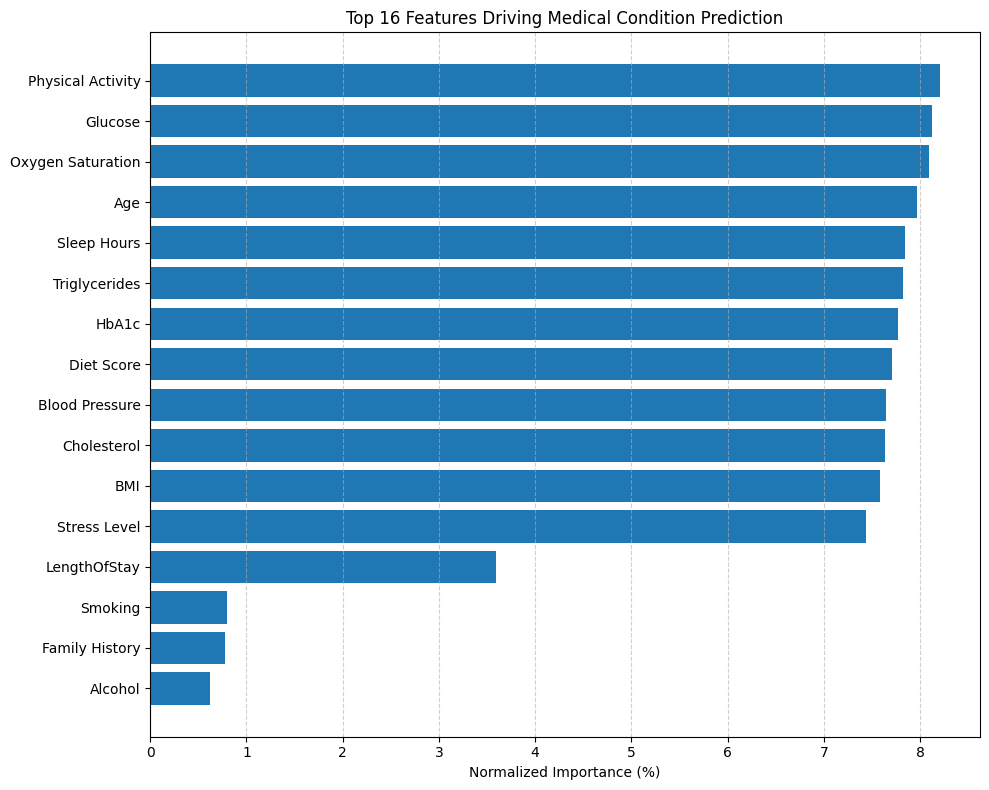

--- Top 16 Feature Importance (Normalized) ---
              Feature  Importance  Normalized Importance
11  Physical Activity        7101               8.213141
1             Glucose        7026               8.126395
4   Oxygen Saturation        7000               8.096323
0                 Age        6890               7.969095
15        Sleep Hours        6786               7.848807
7       Triglycerides        6761               7.819892
8               HbA1c        6720               7.772470
12         Diet Score        6661               7.704230
2      Blood Pressure        6607               7.641772
6         Cholesterol        6602               7.635989
3                 BMI        6555               7.581628
14       Stress Level        6433               7.440521
5        LengthOfStay        3109               3.595924
9             Smoking         691               0.799223
13     Family History         676               0.781873
10            Alcohol         537        

In [19]:
importance = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': lgb_model_optimized.feature_importances_
})

importance = importance.sort_values(by='Importance', ascending=False)
total_importance = importance['Importance'].sum()
importance['Normalized Importance'] = (importance['Importance'] / total_importance) * 100

top_n = 16
top_importance = importance.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(
    top_importance['Feature'][::-1], 
    top_importance['Normalized Importance'][::-1],
    color='#1f77b4'
)
plt.xlabel('Normalized Importance (%)')
plt.title(f'Top {top_n} Features Driving Medical Condition Prediction')
plt.gca().tick_params(axis='y', labelsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"--- Top {top_n} Feature Importance (Normalized) ---")
print(top_importance)